# Seattle Crime #

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time

In [2]:
start_time = time.time()

### Let's start off by looking at our data ###

In [3]:
df = pd.read_csv("SPD_Crime_Data.csv")
df.head()

,Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-044620,12605873663,02/05/2020 10:10:00 AM,NaN,02/05/2020 11:24:31 AM,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
1,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/04/2020 08:00:00 AM,02/05/2020 10:06:28 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/02/2020 09:30:00 PM,02/05/2020 09:39:33 AM,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
3,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 02:21:00 AM,02/05/2020 03:30:55 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
4,2020-044076,12605081469,02/05/2020 12:51:21 AM,NaN,02/05/2020 12:51:31 AM,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036236 entries, 0 to 1036235
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Report Number           1036236 non-null  object 
 1   Offense ID              1036236 non-null  int64  
 2   Offense Start DateTime  1034989 non-null  object 
 3   Offense End DateTime    583385 non-null   object 
 4   Report DateTime         1036236 non-null  object 
 5   Group A B               1036236 non-null  object 
 6   Crime Against Category  1036236 non-null  object 
 7   Offense Parent Group    1036236 non-null  object 
 8   Offense                 1036236 non-null  object 
 9   Offense Code            1036236 non-null  object 
 10  Precinct                1036232 non-null  object 
 11  Sector                  1036234 non-null  object 
 12  Beat                    1036234 non-null  object 
 13  MCPP                    1036236 non-null  object 
 14  10

**Let's check for null values**

In [5]:
df.isnull().sum()

Report Number                  0
Offense ID                     0
Offense Start DateTime      1247
Offense End DateTime      452851
Report DateTime                0
Group A B                      0
Crime Against Category         0
Offense Parent Group           0
Offense                        0
Offense Code                   0
Precinct                       4
Sector                         2
Beat                           2
MCPP                           0
100 Block Address          44049
Longitude                      0
Latitude                       0
dtype: int64

**Let's check for duplicate values**

In [6]:
df.drop_duplicates(inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036236 entries, 0 to 1036235
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Report Number           1036236 non-null  object 
 1   Offense ID              1036236 non-null  int64  
 2   Offense Start DateTime  1034989 non-null  object 
 3   Offense End DateTime    583385 non-null   object 
 4   Report DateTime         1036236 non-null  object 
 5   Group A B               1036236 non-null  object 
 6   Crime Against Category  1036236 non-null  object 
 7   Offense Parent Group    1036236 non-null  object 
 8   Offense                 1036236 non-null  object 
 9   Offense Code            1036236 non-null  object 
 10  Precinct                1036232 non-null  object 
 11  Sector                  1036234 non-null  object 
 12  Beat                    1036234 non-null  object 
 13  MCPP                    1036236 non-null  object 
 14  10

## Preprocessing Our Data ##

### 1) Null Values ###

In [7]:
df.isnull().sum()

Report Number                  0
Offense ID                     0
Offense Start DateTime      1247
Offense End DateTime      452851
Report DateTime                0
Group A B                      0
Crime Against Category         0
Offense Parent Group           0
Offense                        0
Offense Code                   0
Precinct                       4
Sector                         2
Beat                           2
MCPP                           0
100 Block Address          44049
Longitude                      0
Latitude                       0
dtype: int64

So we can see that we have null values in our "Offense Start DateTime", "Offense End DateTime", "Precint", "Sector", "Beat", and "100 Block Address" variables. Let's take a closer look at some of the variables, and decide whether we want to eliminate the column entirely, or just eliminate the null values.

**Offense Start DateTime**

"Offense Start DateTime" is described as "Start date and time the offense(s) occurred". We are interested in seeing when the crime started, so we'll simply eliminate the null values. 

In [8]:
df = df.dropna(subset = ["Offense Start DateTime"])

Let's check the null values for "Offense Start DateTime" again to make sure we eliminated them

In [9]:
df.isnull().sum()

Report Number                  0
Offense ID                     0
Offense Start DateTime         0
Offense End DateTime      451752
Report DateTime                0
Group A B                      0
Crime Against Category         0
Offense Parent Group           0
Offense                        0
Offense Code                   0
Precinct                       4
Sector                         2
Beat                           2
MCPP                           0
100 Block Address          43857
Longitude                      0
Latitude                       0
dtype: int64

**Offense End DateTime**

The "Offense End DateTime" variable is described as the "end date and time the offense(s) occurred..". We are not interested in when the crime ended, so we'll eliminate the column entirely. 

In [10]:
df =df.drop(["Offense End DateTime"], axis = 1)
df

,Report Number,Offense ID,Offense Start DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-044620,12605873663,02/05/2020 10:10:00 AM,02/05/2020 11:24:31 AM,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
1,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/05/2020 10:06:28 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/05/2020 09:39:33 AM,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
3,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 03:30:55 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
4,2020-044076,12605081469,02/05/2020 12:51:21 AM,02/05/2020 12:51:31 AM,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036231,2013-247888,7687554356,07/13/2013 01:00:00 AM,07/13/2013 06:37:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,SW,F,F1,PIGEON POINT,41XX BLOCK OF 20TH AVE SW,-122.359028,47.565702
1036232,2013-227022,7682354808,06/26/2013 11:00:00 AM,06/29/2013 09:43:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,W,Q,Q3,QUEEN ANNE,1ST AVE N / VALLEY ST,-122.355386,47.626251
1036233,2012-045494,7672915592,02/14/2012 03:04:00 PM,02/14/2012 03:04:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,U,U1,ROOSEVELT/RAVENNA,73XX BLOCK OF ROOSEVELT WAY NE,-122.317464,47.681894
1036234,2010-328592,7692227482,09/19/2010 04:59:00 PM,09/19/2010 04:59:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,W,M,M3,DOWNTOWN COMMERCIAL,5XX BLOCK OF PIKE ST,-122.335018,47.610909


**Precint, Sector and Beat**

Seattle has 5 precincts, or police station areas. They are: North, East, South, West and Southwest. Then, there are smaller geographical areas within the precints called sectors. Finally, each sector is divided into 3 smaller sections called beats, which individual patrol officers are assigned responsibility for. We'll eliminate the precinct column, to narrow down the location of crimes a little more. We'll keep the sector and beat column, but eliminate the null values.

In [11]:
#Dropping Precinct column
df =df.drop(["Precinct"], axis = 1)
df

,Report Number,Offense ID,Offense Start DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-044620,12605873663,02/05/2020 10:10:00 AM,02/05/2020 11:24:31 AM,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
1,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/05/2020 10:06:28 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/05/2020 09:39:33 AM,A,PROPERTY,ROBBERY,Robbery,120,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
3,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 03:30:55 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
4,2020-044076,12605081469,02/05/2020 12:51:21 AM,02/05/2020 12:51:31 AM,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036231,2013-247888,7687554356,07/13/2013 01:00:00 AM,07/13/2013 06:37:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,F,F1,PIGEON POINT,41XX BLOCK OF 20TH AVE SW,-122.359028,47.565702
1036232,2013-227022,7682354808,06/26/2013 11:00:00 AM,06/29/2013 09:43:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,Q,Q3,QUEEN ANNE,1ST AVE N / VALLEY ST,-122.355386,47.626251
1036233,2012-045494,7672915592,02/14/2012 03:04:00 PM,02/14/2012 03:04:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,U,U1,ROOSEVELT/RAVENNA,73XX BLOCK OF ROOSEVELT WAY NE,-122.317464,47.681894
1036234,2010-328592,7692227482,09/19/2010 04:59:00 PM,09/19/2010 04:59:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,M,M3,DOWNTOWN COMMERCIAL,5XX BLOCK OF PIKE ST,-122.335018,47.610909


In [12]:
#Dropping null values in the sector and beat column
df = df.dropna(subset = ["Sector", "Beat"])

Let's check the null values again

In [13]:
df.isnull().sum()

Report Number                 0
Offense ID                    0
Offense Start DateTime        0
Report DateTime               0
Group A B                     0
Crime Against Category        0
Offense Parent Group          0
Offense                       0
Offense Code                  0
Sector                        0
Beat                          0
MCPP                          0
100 Block Address         43857
Longitude                     0
Latitude                      0
dtype: int64

**100 Block Address**

Lastly, we have the "100 Block Address" column. Since the information in this column is censored and doesn't give us very accurate locations, we'll eliminate the entire column.

In [14]:
df =df.drop(["100 Block Address"], axis = 1)
df

,Report Number,Offense ID,Offense Start DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Sector,Beat,MCPP,Longitude,Latitude
0,2020-044620,12605873663,02/05/2020 10:10:00 AM,02/05/2020 11:24:31 AM,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,Q,Q1,MAGNOLIA,-122.385974,47.649387
1,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/05/2020 10:06:28 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,J,J3,ROOSEVELT/RAVENNA,-122.323399,47.675118
2,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/05/2020 09:39:33 AM,A,PROPERTY,ROBBERY,Robbery,120,U,U3,ROOSEVELT/RAVENNA,-122.299552,47.666384
3,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 03:30:55 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,Q,Q1,MAGNOLIA,-122.384865,47.642927
4,2020-044076,12605081469,02/05/2020 12:51:21 AM,02/05/2020 12:51:31 AM,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,B,B2,BALLARD SOUTH,-122.366195,47.662193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036231,2013-247888,7687554356,07/13/2013 01:00:00 AM,07/13/2013 06:37:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,F,F1,PIGEON POINT,-122.359028,47.565702
1036232,2013-227022,7682354808,06/26/2013 11:00:00 AM,06/29/2013 09:43:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,Q,Q3,QUEEN ANNE,-122.355386,47.626251
1036233,2012-045494,7672915592,02/14/2012 03:04:00 PM,02/14/2012 03:04:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,U,U1,ROOSEVELT/RAVENNA,-122.317464,47.681894
1036234,2010-328592,7692227482,09/19/2010 04:59:00 PM,09/19/2010 04:59:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,M,M3,DOWNTOWN COMMERCIAL,-122.335018,47.610909


Let's take another look at our null values

In [15]:
df.isnull().sum()

Report Number             0
Offense ID                0
Offense Start DateTime    0
Report DateTime           0
Group A B                 0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
Offense Code              0
Sector                    0
Beat                      0
MCPP                      0
Longitude                 0
Latitude                  0
dtype: int64

We can now move onto cleaning other parts of our data

### 2) Eliminating Other Variables ###

We can eliminate some of the following variables: 

* Report Number, since that won't help us with future predictions
* Offense ID, a unique identifier that also won't help with future predictions
* Report DateTime, since the time a crime is reported can differ from when it actually started
* Group A B, since no additional information is given on what the different groups represent 
* Offense Parent Group, since we have a separate column for what the actual offense was
* Offense Code, since we already have the title of the offense via our Offense variable
* Longitude, since the actual longitude is censored to within 100 blocks
* Latitude, since latitude is also censored to within 100 blocks

In [16]:
#Eliminating above mentioned variables
df = df.drop(columns = ["Report Number", "Offense ID", "Report DateTime", "Group A B", "Offense Parent Group", "Offense Code", "Longitude", "Latitude"])
df

,Offense Start DateTime,Crime Against Category,Offense,Sector,Beat,MCPP
0,02/05/2020 10:10:00 AM,SOCIETY,Drug/Narcotic Violations,Q,Q1,MAGNOLIA
1,02/03/2020 08:00:00 AM,PROPERTY,Theft of Motor Vehicle Parts or Accessories,J,J3,ROOSEVELT/RAVENNA
2,02/02/2020 08:30:00 PM,PROPERTY,Robbery,U,U3,ROOSEVELT/RAVENNA
3,02/05/2020 01:17:00 AM,PROPERTY,Destruction/Damage/Vandalism of Property,Q,Q1,MAGNOLIA
4,02/05/2020 12:51:21 AM,SOCIETY,Driving Under the Influence,B,B2,BALLARD SOUTH
...,...,...,...,...,...,...
1036231,07/13/2013 01:00:00 AM,PROPERTY,Motor Vehicle Theft,F,F1,PIGEON POINT
1036232,06/26/2013 11:00:00 AM,PROPERTY,Motor Vehicle Theft,Q,Q3,QUEEN ANNE
1036233,02/14/2012 03:04:00 PM,PROPERTY,Shoplifting,U,U1,ROOSEVELT/RAVENNA
1036234,09/19/2010 04:59:00 PM,PROPERTY,Shoplifting,M,M3,DOWNTOWN COMMERCIAL


### 3) Data Types ###

We need to make sure our data is in appropiate format, to use for our models. Let's take a look at the different types of data, and see if we can convert into usable formats.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034987 entries, 0 to 1036235
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   Offense Start DateTime  1034987 non-null  object
 1   Crime Against Category  1034987 non-null  object
 2   Offense                 1034987 non-null  object
 3   Sector                  1034987 non-null  object
 4   Beat                    1034987 non-null  object
 5   MCPP                    1034987 non-null  object
dtypes: object(6)
memory usage: 55.3+ MB


**Offense Start Date Time**

Let's start by converting our "Offense Start Date Time" into a datetime type.

In [18]:
df["Offense Start DateTime"] = df["Offense Start DateTime"].astype('datetime64[ns]')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034987 entries, 0 to 1036235
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   Offense Start DateTime  1034987 non-null  datetime64[ns]
 1   Crime Against Category  1034987 non-null  object        
 2   Offense                 1034987 non-null  object        
 3   Sector                  1034987 non-null  object        
 4   Beat                    1034987 non-null  object        
 5   MCPP                    1034987 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 55.3+ MB


Let's split our datetime column into separate columns for day and time that the crime occured.

In [20]:
df['Time'] = pd.to_datetime(df['Offense Start DateTime']).dt.time
df['Day'] = pd.to_datetime(df['Offense Start DateTime']).dt.weekday
df['Year'] = pd.to_datetime(df['Offense Start DateTime']).dt.year

In [21]:
df

,Offense Start DateTime,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
0,2020-02-05 10:10:00,SOCIETY,Drug/Narcotic Violations,Q,Q1,MAGNOLIA,10:10:00,2,2020
1,2020-02-03 08:00:00,PROPERTY,Theft of Motor Vehicle Parts or Accessories,J,J3,ROOSEVELT/RAVENNA,08:00:00,0,2020
2,2020-02-02 20:30:00,PROPERTY,Robbery,U,U3,ROOSEVELT/RAVENNA,20:30:00,6,2020
3,2020-02-05 01:17:00,PROPERTY,Destruction/Damage/Vandalism of Property,Q,Q1,MAGNOLIA,01:17:00,2,2020
4,2020-02-05 00:51:21,SOCIETY,Driving Under the Influence,B,B2,BALLARD SOUTH,00:51:21,2,2020
...,...,...,...,...,...,...,...,...,...
1036231,2013-07-13 01:00:00,PROPERTY,Motor Vehicle Theft,F,F1,PIGEON POINT,01:00:00,5,2013
1036232,2013-06-26 11:00:00,PROPERTY,Motor Vehicle Theft,Q,Q3,QUEEN ANNE,11:00:00,2,2013
1036233,2012-02-14 15:04:00,PROPERTY,Shoplifting,U,U1,ROOSEVELT/RAVENNA,15:04:00,1,2012
1036234,2010-09-19 16:59:00,PROPERTY,Shoplifting,M,M3,DOWNTOWN COMMERCIAL,16:59:00,6,2010


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034987 entries, 0 to 1036235
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   Offense Start DateTime  1034987 non-null  datetime64[ns]
 1   Crime Against Category  1034987 non-null  object        
 2   Offense                 1034987 non-null  object        
 3   Sector                  1034987 non-null  object        
 4   Beat                    1034987 non-null  object        
 5   MCPP                    1034987 non-null  object        
 6   Time                    1034987 non-null  object        
 7   Day                     1034987 non-null  int64         
 8   Year                    1034987 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 79.0+ MB


In [23]:
df["Year"] = df["Year"].astype('str').astype('int64')

In [24]:
df = df[df["Year"] >= 2021]

Let's remove the Offense Start DateTime column, since we split up our data

In [25]:
df = df.drop(["Offense Start DateTime"], axis = 1)

In [26]:
df

,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
851429,PROPERTY,Stolen Property Offenses,L,L3,LAKECITY,19:50:00,6,2021
853072,PROPERTY,Destruction/Damage/Vandalism of Property,N,N3,GREENWOOD,18:38:00,6,2021
853215,PROPERTY,Motor Vehicle Theft,W,W1,ALKI,23:59:00,0,2021
853440,PROPERTY,Stolen Property Offenses,F,F1,NORTH DELRIDGE,07:46:00,1,2021
853655,PROPERTY,Stolen Property Offenses,O,O2,SODO,04:16:00,4,2021
...,...,...,...,...,...,...,...,...
1036220,PROPERTY,Motor Vehicle Theft,R,R1,MID BEACON HILL,06:00:00,3,2022
1036221,PERSON,Simple Assault,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS,13:34:00,4,2022
1036222,PERSON,Simple Assault,F,F1,PIGEON POINT,11:24:00,1,2022
1036223,PERSON,Simple Assault,F,F2,SOUTH DELRIDGE,16:29:00,0,2022


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155575 entries, 851429 to 1036224
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Crime Against Category  155575 non-null  object
 1   Offense                 155575 non-null  object
 2   Sector                  155575 non-null  object
 3   Beat                    155575 non-null  object
 4   MCPP                    155575 non-null  object
 5   Time                    155575 non-null  object
 6   Day                     155575 non-null  int64 
 7   Year                    155575 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 10.7+ MB


**Crime Against Category**

Let's look at the unique values of our Crime Against Category variable, and then convert those values into numerical categories.

In [28]:
df["Crime Against Category"].value_counts()

PROPERTY       120153
PERSON          25576
SOCIETY          9839
NOT_A_CRIME         7
Name: Crime Against Category, dtype: int64

In [29]:
#Converting into categories
df["Crime Against Category"] = df["Crime Against Category"].astype("category").cat.codes

In [30]:
df["Crime Against Category"].unique()

array([2, 1, 3, 0], dtype=int8)

**Sector, Beat, and MCPP**

Let's do the same thing with our Sector, Beat, and MCPP variables

In [31]:
#Converting values into categories
df["Sector"] = df["Sector"].astype("category").cat.codes
df["Beat"] = df["Beat"].astype("category").cat.codes
df["MCPP"] = df["MCPP"].astype("category").cat.codes

Let's see what our data looks like so far

In [32]:
df

,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
851429,2,Stolen Property Offenses,10,28,29,19:50:00,6,2021
853072,2,Destruction/Damage/Vandalism of Property,12,34,24,18:38:00,6,2021
853215,2,Motor Vehicle Theft,20,52,2,23:59:00,0,2021
853440,2,Stolen Property Offenses,6,14,42,07:46:00,1,2021
853655,2,Stolen Property Offenses,13,36,54,04:16:00,4,2021
...,...,...,...,...,...,...,...,...
1036220,2,Motor Vehicle Theft,16,42,34,06:00:00,3,2022
1036221,1,Simple Assault,6,15,51,13:34:00,4,2022
1036222,1,Simple Assault,6,14,45,11:24:00,1,2022
1036223,1,Simple Assault,6,15,56,16:29:00,0,2022


**Time, Day, and Year**

Lastly, let's do the exact same thing to our Time and Day variables

In [33]:
#Converting values into categories
df["Time"] = df["Time"].astype("category").cat.codes
df["Day"] = df["Day"].astype("category").cat.codes
df["Year"] = df["Year"].astype("category").cat.codes

Let's take a look at our updated dataset

In [34]:
df

,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
851429,2,Stolen Property Offenses,10,28,29,1190,6,0
853072,2,Destruction/Damage/Vandalism of Property,12,34,24,1118,6,0
853215,2,Motor Vehicle Theft,20,52,2,1439,0,0
853440,2,Stolen Property Offenses,6,14,42,466,1,0
853655,2,Stolen Property Offenses,13,36,54,256,4,0
...,...,...,...,...,...,...,...,...
1036220,2,Motor Vehicle Theft,16,42,34,360,3,1
1036221,1,Simple Assault,6,15,51,814,4,1
1036222,1,Simple Assault,6,14,45,684,1,1
1036223,1,Simple Assault,6,15,56,989,0,1


We can now start trying to create our initial model

In [35]:
#df["Offense"].value_counts()

In [36]:
#df = df.drop(df[(df["Offense"] == 'Gambling Equipment Violation') & (df["Offense"] == 'Human Trafficking, Involuntary Servitude') & (df["Offense"] == "Operating/Promoting/Assisting Gambling")].index, inplace = True)
#df = df[df["Offense"].str.contains("Gambling Equipment Violation") == False]
#df = df[df["Offense"].str.contains("Human Trafficking, Involuntary Servitude") == False]
#df = df[df["Offense"].str.contains("Operating/Promoting/Assisting Gambling") == False]                             

In [37]:
#df["Offense"].value_counts()

In [38]:
df = df[~df['Offense'].isin(df['Offense'].value_counts().lt(5000).pipe(lambda s: s[s].index))]

In [39]:
df["Offense"].value_counts()

Burglary/Breaking & Entering                   19722
Theft From Motor Vehicle                       19390
Destruction/Damage/Vandalism of Property       15546
All Other Larceny                              13767
Motor Vehicle Theft                            13393
Theft of Motor Vehicle Parts or Accessories    12853
Simple Assault                                 10494
Shoplifting                                     8736
Aggravated Assault                              7258
Intimidation                                    6225
Name: Offense, dtype: int64

In [40]:
df

,Crime Against Category,Offense,Sector,Beat,MCPP,Time,Day,Year
853072,2,Destruction/Damage/Vandalism of Property,12,34,24,1118,6,0
853215,2,Motor Vehicle Theft,20,52,2,1439,0,0
853796,2,Motor Vehicle Theft,3,7,31,44,1,0
853951,2,Destruction/Damage/Vandalism of Property,4,8,5,25,0,0
853952,2,All Other Larceny,2,2,4,874,1,0
...,...,...,...,...,...,...,...,...
1036218,2,Theft of Motor Vehicle Parts or Accessories,10,28,29,0,2,1
1036220,2,Motor Vehicle Theft,16,42,34,360,3,1
1036221,1,Simple Assault,6,15,51,814,4,1
1036222,1,Simple Assault,6,14,45,684,1,1


## Initial Model ##

Let's start off by first identifying our target variable

In [41]:
X = df.drop("Offense", axis = 1)

#Target Variable
y = df["Offense"]

Now we'll split our data using Train Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

We'll scale our data, to make it easier for the model to work with

In [43]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

In [44]:
sm = SMOTE(random_state = 1)
X_train, y_train = sm.fit_sample(X_train, y_train)

#ros = RandomOverSampler(random_state=1)
#X_train, y_train = ros.fit_resample(X_train, y_train)

Now it's time to initialize our model

In [45]:
#Initializing our model
#InitialModel = LogisticRegression(multi_class='ovr', random_state= 1)

Now we'll fit our model

In [46]:
#InitialModel.fit(X_train, y_train)

In [47]:
#y_train_pred = InitialModel.predict(X_train)
#y_test_pred = InitialModel.predict(X_test)

In [48]:
#print(classification_report(y_train, y_train_pred))

In [49]:
#print(classification_report(y_test, y_test_pred))

## Random Forest Model ##

In [50]:
rf = RandomForestClassifier(criterion= "entropy",random_state = 1,  max_depth = 5)

rf.fit(X_train, y_train)
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

In [51]:
print(classification_report(y_train, rf_train_pred))

                                             precision    recall  f1-score   support

                         Aggravated Assault       0.43      0.37      0.40     14827
                          All Other Larceny       0.21      0.17      0.19     14827
               Burglary/Breaking & Entering       0.25      0.38      0.30     14827
   Destruction/Damage/Vandalism of Property       0.27      0.08      0.13     14827
                               Intimidation       0.42      0.56      0.48     14827
                        Motor Vehicle Theft       0.23      0.26      0.24     14827
                                Shoplifting       0.27      0.73      0.40     14827
                             Simple Assault       0.40      0.32      0.36     14827
                   Theft From Motor Vehicle       0.28      0.05      0.09     14827
Theft of Motor Vehicle Parts or Accessories       0.25      0.07      0.12     14827

                                   accuracy                    

In [52]:
print(classification_report(y_test, rf_test_pred))

                                             precision    recall  f1-score   support

                         Aggravated Assault       0.37      0.33      0.35      1840
                          All Other Larceny       0.19      0.17      0.18      3412
               Burglary/Breaking & Entering       0.29      0.37      0.32      4895
   Destruction/Damage/Vandalism of Property       0.24      0.07      0.11      3862
                               Intimidation       0.33      0.54      0.41      1559
                        Motor Vehicle Theft       0.18      0.24      0.21      3344
                                Shoplifting       0.17      0.72      0.28      2163
                             Simple Assault       0.48      0.33      0.39      2611
                   Theft From Motor Vehicle       0.31      0.05      0.09      4895
Theft of Motor Vehicle Parts or Accessories       0.20      0.07      0.11      3265

                                   accuracy                    

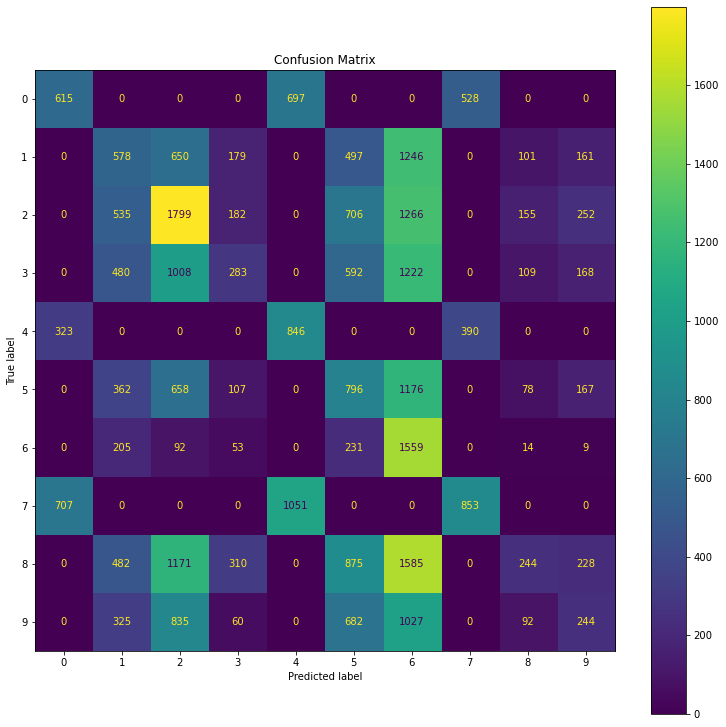

In [66]:
#fig, ax = plt.subplots(figsize=(15,15))
#interp.plot_confusion_matrix(rf, X_test, y_test);

#np.interp.plot_confusion_matrix(figsize=(10,10))

cm = confusion_matrix(y_test, rf_test_pred);
cmp = ConfusionMatrixDisplay(cm);
fig, ax = plt.subplots(figsize=(13,13));
cmp.plot(ax=ax);
cmp.ax_.set_title("Confusion Matrix");

0) Aggravated Assault

1) All Other Larceny

2) Burglary/Breaking & Entering

3) Destruction/Damage/Vandalism of Property

4) Intimidation

5) Motor Vehicle Theft

6) Shoplifting

7) Simple Assault

8) Theft From Motor Vehicle

9) Theft of Motor Vehicle Parts or Accessories


### Crime Confusion Matrix ###

**0) Aggravated Assault**

* 615 crimes were correctly predicted as being "aggravated assault" crimes
* 1,225 crimes were wrongly predicted as not being "aggravated assault" crimes
* 1,030 crimes were wrongly predicted as being "aggravated assault" crimes
* 28,976 crimes were correctly predicted as not being "aggravated assault" crimes

**1) All Other Larceny**

* 578 crimes were correctly predicted as being "all other larceny" crimes
* 2,834 crimes were wrongly predicted as not being "all other larceny" crimes
* 2,389 crimes were wrongly precicted as being "all other larceny" crimes
* 26,045 crimes were correctly predicted as not being "all other larceny" crimes

**2) Burglary/Breaking & Entering**

* 1799 crimes were correctly predicted as being "burglary/breaking & entering" crimes
* 3,096 crimes were wrongly predicted as not being "burglary/breaking & entering" crimes
* 4,414 crimes were wrongly predicted as being "burglary/breaking & entering" crimes
* 23,722 crimes were correctly predicted as not being "burglary/breaking & entering" crimes

**3) Destruction/Damage/Vandalism of Property**

* 283 crimes were correctly predicted as being "destruction/damage/vandalism of property" crimes
* 3,579 crimes were wrongly predicted as not being "destruction/damage/vandalism of property" crimes
* 891 crimes were wrongly predicted as being "destruction/damage/vandalism of property" crimes
* 28,942 crimes were correctly predicted as not being "destruction/damage/vandalism of property" crimes

**4) Intimidation**

* 846 crimes were correctly predicted as being "intimidation" crimes
* 713 crimes were wrongly predicted as not being "intimidation" crimes
* 1,748 crimes were wrongly predicted as being "intimidation" crimes
* 29, 559 crimes were correctly predicted as not being "intimidation" crimes

**5) Motor Vehicle Theft**

* 796 crimes were correctly predicted as being "motor vehicle theft" crimes
* 2,548 crimes were wrongly predicted as not being "motor vehicle theft" crimes
* 3,583 crimes were wrongly predicted as being "motor vehicle theft" crimes
* 27,841 crimes were correctly predicted as not being "motor vehicle theft" crimes

**6) Shoplifting**

* 1559 crimes were correctly predicted as being "shoplifting" crimes
* 424 crimes were wrongly predicted as not being "shoplifting" crimes
* 7,522 crimes were wrongly predicted as being "shoplifting" crimes
* 27,652 crimes were correctly predicted as not being "shoplifting" crimes

**7) Simple Assault**

* 853 crimes were correctly predicted as being "simple assault" crimes
* 1,758 crimes were wrongly predicted as not being "simple assault" crimes
* 918 crimes were wrongly predicted as being "simple assault" crimes
* 30,993 crimes were correctly predicted as not being "simple assault" crimes

**8) Theft From Motor Vehicle**

* 244 crimes were correctly predicted as being "theft from motor vehicle" crimes
* 4,651 crimes were wrongly predicted as not being "theft from motor vehicle" crimes
* 549 crimes were wrongly predicted as being "theft from motor vehicle" crimes
* 31,282 crimes were correctly predicted as not being "theft from motor vehicle" crimes

**9)  Theft of Motor Vehicle Parts or Accessories**

* 244 crimes were correctly predicted as being "theft of motor vehicle parts or accessories" crimes
* 3,021 crimes were wrongly predicted as not being "theft of motor vehicle parts or accessories" crimes
* 985 crimes were wrongly predicted as not being "theft of motor vehicle parts or accessories" crimes
* 26,966 crimes were correctly predicted as not being "theft of motor vehicle parts or accessories" crimes

### Crime Classification Report ###

## Random Forest Tuning ##

In [54]:
rf2 = RandomForestClassifier()

param_grid = {
    'criterion': ['entropy'],
    'random_state': [1],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [0.2, 0.25, 0.3, 0.35, 0.4 ],
    'min_samples_leaf': [0.1, 0.2, 0.3]
}


gs_rf = GridSearchCV(rf2, param_grid)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'random_state': 1}

In [55]:
#gs_forest_train_pred = gs_rf.predict(X_train)
#print(classification_report(y_train, gs_forest_train_pred))

In [56]:
#gs_forest_test_pred = gs_rf.predict(X_test)
#print(classification_report(y_test, gs_forest_test_pred))

In [57]:
rf3 = RandomForestClassifier()

param_grid2 = {
    'criterion': ['entropy'],
    'random_state': [1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [0.24, 0.25, 0.26],
    'min_samples_leaf': [0.1, 0.12, 0.13]
}


gs_rf2 = GridSearchCV(rf2, param_grid)
gs_rf2.fit(X_train, y_train)
gs_rf2.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'random_state': 1}

In [58]:
rf4 = RandomForestClassifier(criterion= "entropy", random_state = 1,  max_depth = 3, min_samples_split= 0.2, min_samples_leaf = 0.1,  )

rf4.fit(X_train, y_train)
rf_train_pred2 = rf4.predict(X_train)
rf_test_pred2 = rf4.predict(X_test)

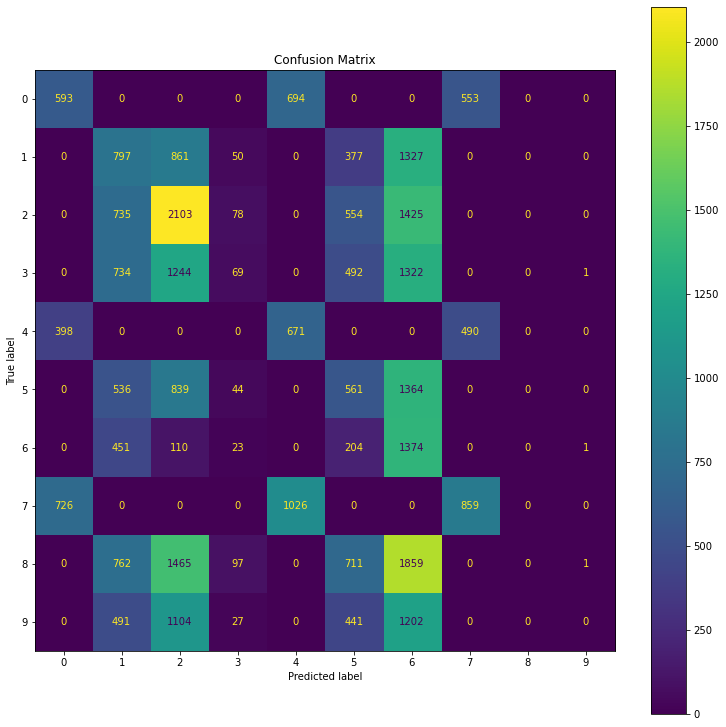

In [59]:
cm2 = confusion_matrix(y_test, rf_test_pred2);
cmp2 = ConfusionMatrixDisplay(cm2);
fig, ax = plt.subplots(figsize=(13,13));
cmp2.plot(ax=ax);
cmp2.ax_.set_title("Confusion Matrix");

In [60]:
print(classification_report(y_train, rf_train_pred2))

C:\Users\aleja\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                             precision    recall  f1-score   support

                         Aggravated Assault       0.37      0.32      0.34     14827
                          All Other Larceny       0.19      0.24      0.21     14827
               Burglary/Breaking & Entering       0.23      0.44      0.30     14827
   Destruction/Damage/Vandalism of Property       0.18      0.02      0.03     14827
                               Intimidation       0.38      0.45      0.41     14827
                        Motor Vehicle Theft       0.20      0.18      0.19     14827
                                Shoplifting       0.23      0.65      0.34     14827
                             Simple Assault       0.35      0.34      0.35     14827
                   Theft From Motor Vehicle       0.00      0.00      0.00     14827
Theft of Motor Vehicle Parts or Accessories       0.11      0.00      0.00     14827

                                   accuracy                    

In [61]:
print(classification_report(y_test, rf_test_pred2))

                                             precision    recall  f1-score   support

                         Aggravated Assault       0.35      0.32      0.33      1840
                          All Other Larceny       0.18      0.23      0.20      3412
               Burglary/Breaking & Entering       0.27      0.43      0.33      4895
   Destruction/Damage/Vandalism of Property       0.18      0.02      0.03      3862
                               Intimidation       0.28      0.43      0.34      1559
                        Motor Vehicle Theft       0.17      0.17      0.17      3344
                                Shoplifting       0.14      0.64      0.23      2163
                             Simple Assault       0.45      0.33      0.38      2611
                   Theft From Motor Vehicle       0.00      0.00      0.00      4895
Theft of Motor Vehicle Parts or Accessories       0.00      0.00      0.00      3265

                                   accuracy                    

In [62]:
print ("My program took", time.time() - start_time, "to run")

My program took 2517.303290605545 to run
